<a href="https://colab.research.google.com/github/jharviy/fcc_machinelearning/blob/main/cat_v_dog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  # This command only in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
import numpy as np
import matplotlib.pyplot as plt

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
# Get project files
!wget https://cdn.freecodecamp.org/project-data/cats-and-dogs/cats_and_dogs.zip

!unzip cats_and_dogs.zip

PATH = 'cats_and_dogs'

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
test_dir = os.path.join(PATH, 'test')

# Get number of files in each directory. The train and validation directories
# each have the subdirectories "dogs" and "cats".
total_train = sum([len(files) for r, d, files in os.walk(train_dir)])
total_val = sum([len(files) for r, d, files in os.walk(validation_dir)])
total_test = len(os.listdir(test_dir))

# Variables for pre-processing and training.
batch_size = 128
epochs = 15
IMG_HEIGHT = 150
IMG_WIDTH = 150

In [3]:
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)

In [4]:
# Make a subdirectory under test_dir and move content to the made directory
TEST_SUBDIR = "/testimages"

try:
  os.makedirs(test_dir + TEST_SUBDIR)

  for content in os.listdir(test_dir):
    source_path = os.path.join(test_dir, content)
    destination_path = os.path.join(test_dir + TEST_SUBDIR, content)

    if not os.path.isdir(source_path):
      os.rename(source_path, destination_path)  # Rename of path will be able to move the object

except OSError:
  print(TEST_SUBDIR + " directory already exists")

In [5]:
# 3
train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
validation_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
test_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

train_data_gen = train_image_generator.flow_from_directory(train_dir,
                                                           target_size = IMG_SIZE,
                                                           batch_size = batch_size,
                                                           class_mode='binary')
val_data_gen = validation_image_generator.flow_from_directory(validation_dir,
                                                              target_size = IMG_SIZE,
                                                              batch_size = batch_size,
                                                              class_mode='binary')
test_data_gen = test_image_generator.flow_from_directory(test_dir,
                                                         target_size = IMG_SIZE,
                                                         batch_size = batch_size,
                                                         class_mode = None,
                                                         shuffle=False)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 50 images belonging to 1 classes.


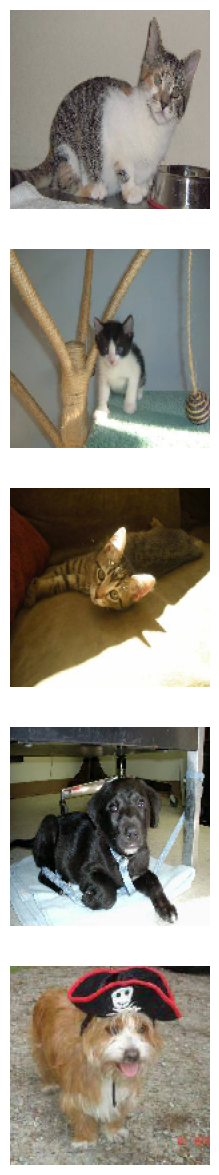

In [6]:
# 4
def plotImages(images_arr, probabilities = False):
    fig, axes = plt.subplots(len(images_arr), 1, figsize=(5,len(images_arr) * 3))
    if probabilities is False:
      for img, ax in zip( images_arr, axes):
          ax.imshow(img)
          ax.axis('off')
    else:
      for img, probability, ax in zip( images_arr, probabilities, axes):
          ax.imshow(img)
          ax.axis('off')
          if probability > 0.5:
              ax.set_title("%.2f" % (probability*100) + "% dog")
          else:
              ax.set_title("%.2f" % ((1-probability)*100) + "% cat")
    plt.show()

sample_training_images, _ = next(train_data_gen)
plotImages(sample_training_images[:5])


In [7]:
# 5
train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255,
                                                                        rotation_range=20,  # Random rotation between -20 and +20 degrees
                                                                        width_shift_range=0.1,  # Random horizontal shift within 10% of the image width
                                                                        height_shift_range=0.1,  # Random vertical shift within 10% of the image height
                                                                        zoom_range=0.2,  # Random zoom between 0.8 and 1.2
                                                                        horizontal_flip=True,  # Randomly flip the images horizontally
                                                                        #vertical_flip=True  # Randomly flip the images vertically
                                                                        )


Found 2000 images belonging to 2 classes.


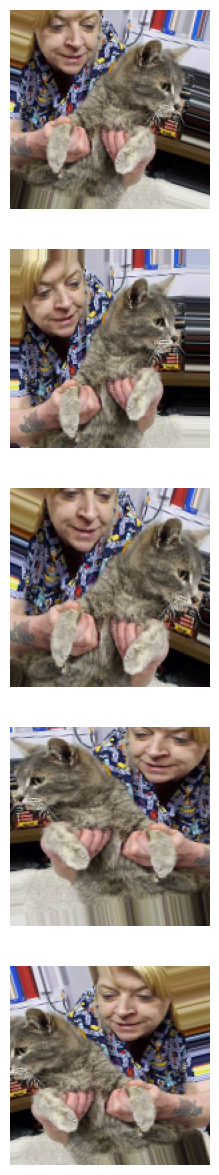

In [8]:
# 6
train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                     directory=train_dir,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

plotImages(augmented_images)

In [9]:
# 7
def make_VGG3model():
  # Three Block VGG Model
  model = Sequential()
  # BLOCK 1
  model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(150, 150, 3)))
  model.add(MaxPooling2D((2, 2)))
  # BLOCK 2
  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))
  # BLOCK 3
  model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPooling2D((2, 2)))

  model.add(Flatten())
  model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))

  model.add(Dense(1, activation='sigmoid'))

  opt = tf.keras.optimizers.SGD(learning_rate=0.001,
                                momentum = 0.9
                                )
  model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
  return model


model = make_VGG3model()             # Three Block VGG Model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 37, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 37, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 18, 128)      0

In [10]:
# 8
history = model.fit(x = train_data_gen,
                    steps_per_epoch = len(train_data_gen),
                    epochs = epochs,
                    validation_data = val_data_gen,
                    validation_steps = len(val_data_gen),
                    )

Epoch 1/15
16/16 [==============================] - 31s 1s/step - loss: 0.8151 - accuracy: 0.5060 - val_loss: 0.7141 - val_accuracy: 0.5000
Epoch 2/15
16/16 [==============================] - 18s 1s/step - loss: 0.6978 - accuracy: 0.5145 - val_loss: 0.6728 - val_accuracy: 0.5960
Epoch 3/15
16/16 [==============================] - 19s 1s/step - loss: 0.6855 - accuracy: 0.5440 - val_loss: 0.6757 - val_accuracy: 0.5520
Epoch 4/15
16/16 [==============================] - 21s 1s/step - loss: 0.6761 - accuracy: 0.5745 - val_loss: 0.6653 - val_accuracy: 0.5950
Epoch 5/15
16/16 [==============================] - 19s 1s/step - loss: 0.6763 - accuracy: 0.5580 - val_loss: 0.6614 - val_accuracy: 0.6160
Epoch 6/15
16/16 [==============================] - 18s 1s/step - loss: 0.6677 - accuracy: 0.5800 - val_loss: 0.6576 - val_accuracy: 0.5960
Epoch 7/15
16/16 [==============================] - 19s 1s/step - loss: 0.6666 - accuracy: 0.6025 - val_loss: 0.6733 - val_accuracy: 0.5610
Epoch 8/15
16/16 [==

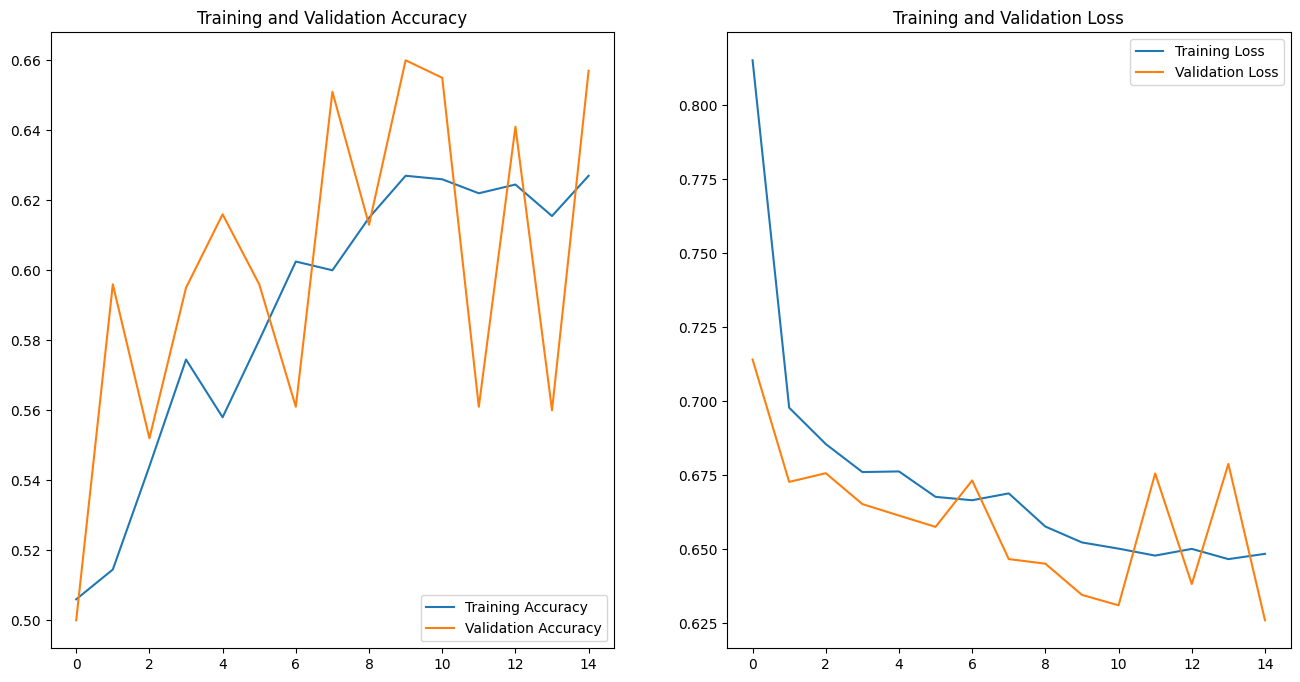

In [11]:
# 9
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 8))
#plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 [==============================] - 1s 638ms/step


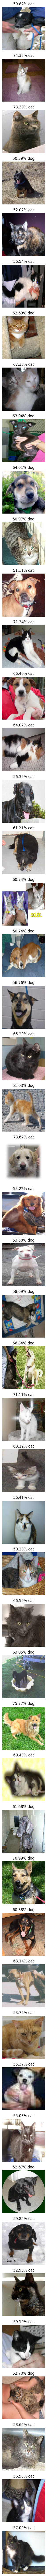

In [12]:
probabilities = model.predict(test_data_gen)
plotImages(next(test_data_gen), probabilities)

In [13]:
# 11
answers =  [1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
            1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
            1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
            1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
            0, 0, 0, 0, 0, 0]

correct = 0

for probability, answer in zip(probabilities, answers):
  #if round(probability) == answer:
  if round(probability[0]) == answer:
    correct +=1

percentage_identified = (correct / len(answers)) * 100

passed_challenge = percentage_identified >= 63

print(f"Your model correctly identified {round(percentage_identified, 2)}% of the images of cats and dogs.")

if passed_challenge:
  print("You passed the challenge!")
else:
  print("You haven't passed yet. Your model should identify at least 63% of the images. Keep trying. You will get it!")

Your model correctly identified 70.0% of the images of cats and dogs.
You passed the challenge!
